In [ ]:
!pip install git+https://github.com/huggingface/transformers.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-gw22frp1
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-gw22frp1
  Resolved https://github.com/huggingface/transformers.git to commit 656e869a4523f6a0ce90b3aacbb05cc8fb5794bb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.1 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.28.0.dev0-py3-none-any.whl size=6895957 sha256=b03fa5f578a63dcf18dc81af103ee9f292be3f1708cd2d92bdc4df3e6d8f824f
  Stored in directory: /tmp/pip-ephem-wheel-cache-_59hm4hu/wheels/f7/92/8c/752ff3bfcd3439805d8bbf641614da3

In [ ]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline
import tensorflow as tf
import pandas as pd
import json
import gc
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv("/content/bbc-text.csv")

In [ ]:
category_count = df['category'].value_counts()

categories = category_count.index

categories

Index(['sport', 'business', 'politics', 'tech', 'entertainment'], dtype='object')

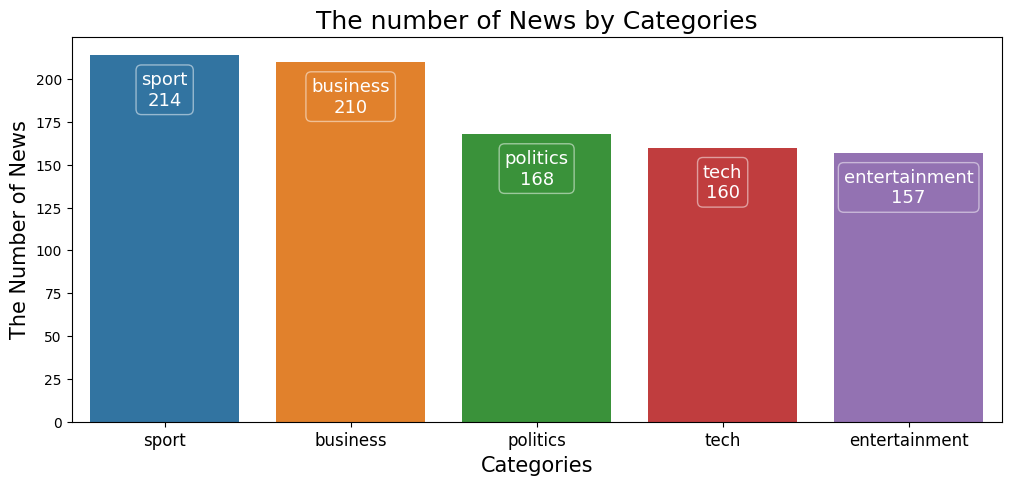

In [ ]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
    
plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of News', size= 15)

plt.xticks(size = 12)

plt.title("The number of News by Categories" , size = 18)

plt.show()

In [ ]:
df['encoded_text'] = df['category'].astype('category').cat.codes

df.head(10)

,category,text,encoded_text
0,tech,tv future in the hands of viewers with home th...,4
1,business,worldcom boss left books alone former worldc...,0
2,sport,tigers wary of farrell gamble leicester say ...,3
3,sport,yeading face newcastle in fa cup premiership s...,3
4,entertainment,ocean s twelve raids box office ocean s twelve...,1
5,politics,howard hits back at mongrel jibe michael howar...,2
6,politics,blair prepares to name poll date tony blair is...,2
7,sport,henman hopes ended in dubai third seed tim hen...,3
8,sport,wilkinson fit to face edinburgh england captai...,3
9,entertainment,last star wars not for children the sixth an...,1


In [ ]:
data_texts = df['text'].to_list()

data_labels = df['encoded_text'].to_list()

In [ ]:
test_labels[0]

4

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )


train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.01, random_state = 0 )

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation = True, padding = True  )

val_encodings = tokenizer(val_texts, truncation = True, padding = True )

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments


training_args = TFTrainingArguments(
    output_dir='./results',          
    num_train_epochs=10,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=1e-5,               
    logging_dir='./logs',            
    eval_steps=100                   
)

with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 5 )


trainer = TFTrainer(
    model=trainer_model,                 
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_79']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

{'eval_loss': 0.0648332138856252}

In [ ]:
# save_directory = "/saved_models" 

model.save_pretrained("model")

tokenizer.save_pretrained("textclass")

('textclass/tokenizer_config.json',
 'textclass/special_tokens_map.json',
 'textclass/vocab.txt',
 'textclass/added_tokens.json')

In [ ]:
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained("/content/textclass")

model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained("/content/model")

Some layers from the model checkpoint at /content/model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/model and are newly initialized: ['dropout_99']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_text = train_texts[0]

train_text , train_labels[0]

('wilkinson return  unlikely  jonny wilkinson looks set to miss the whole of the 2005 rbs six nations.  england s world cup-winning fly-half said last week he was hoping to recover from his latest injury in time to play some role in the championship. but rob andrew  coach of wilkinson s club side newcastle  said that with only two games left to play wilkinson was unlikely to be fit in time.  it would be irresponsible to put him straight into a test match   andrew told the times. wilkinson is recovering from a knee injury which followed long-term neck and arm injuries. he has not played for england since the world cup final in november 2003  since when the stuttering world champions have lost nine of their 14 matches. wilkinson is aiming to make his third start to the season in the zurich premiership match against harlequins on 13 march.  that game is the day after england play italy in the six nations and six days before their final match of the championship against scotland.  we are h

In [ ]:
predict_input = tokenizer_fine_tuned.encode(train_text,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

output = model_fine_tuned(predict_input)[0]
print(output)
prediction_value = tf.argmax(output, axis=1).numpy()[0]
prediction_value

tf.Tensor([[-0.01947324 -0.06444069  0.06976475  0.07944074 -0.0305471 ]], shape=(1, 5), dtype=float32)


3

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
model.push_to_hub("Amite5h/TextClassificationmulticlass")

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

tf_model.h5:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
tokenizer.push_to_hub("Amite5h/TextClassificationmulticlass")

CommitInfo(commit_url='https://huggingface.co/Amite5h/TextClassificationmulticlass/commit/690e566e89834ad4ba7383276d4a70742e834c2b', commit_message='Upload tokenizer', commit_description='', oid='690e566e89834ad4ba7383276d4a70742e834c2b', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained("Amite5h/TextClassificationmulticlass")

model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained("Amite5h/TextClassificationmulticlass")

Some layers from the model checkpoint at Amite5h/TextClassificationmulticlass were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at Amite5h/TextClassificationmulticlass and are newly initialized: ['dropout_119']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained("Amite5h/TextClassificationmulticlass")

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!python3 -m pip install pytextrank

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import spacy
import pytextrank

In [ ]:
!python -m spacy download en

2023-04-10 19:58:24.624903: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 32.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import spacy.cli

spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe("textrank")

In [ ]:
example_text = """Deep learning (also known as deep structured learning) is part of a broader family of machine learning methods based on artificial neural networks with representation learning. Learning can be supervised, semi-supervised or unsupervised. Deep-learning architectures such as deep neural networks, deep belief networks, deep reinforcement learning, recurrent neural networks and convolutional neural networks have been applied to fields including computer vision, speech recognition, natural language processing, machine translation, bioinformatics, drug design, medical image analysis, material inspection and board game programs, where they have produced results comparable to and in some cases surpassing human expert performance. Artificial neural networks (ANNs) were inspired by information processing and distributed communication nodes in biological systems. ANNs have various differences from biological brains. Specifically, neural networks tend to be static and symbolic, while the biological brain of most living organisms is dynamic (plastic) and analogue. The adjective "deep" in deep learning refers to the use of multiple layers in the network. Early work showed that a linear perceptron cannot be a universal classifier, but that a network with a nonpolynomial activation function with one hidden layer of unbounded width can. Deep learning is a modern variation which is concerned with an unbounded number of layers of bounded size, which permits practical application and optimized implementation, while retaining theoretical universality under mild conditions. In deep learning the layers are also permitted to be heterogeneous and to deviate widely from biologically informed connectionist models, for the sake of efficiency, trainability and understandability, whence the structured part."""

In [ ]:
doc = nlp(example_text)

In [ ]:
s = []
for sent in doc._.textrank.summary(limit_phrases=2, limit_sentences=1):
      s.append(sent)

In [ ]:
s[0]

Deep-learning architectures such as deep neural networks, deep belief networks, deep reinforcement learning, recurrent neural networks and convolutional neural networks have been applied to fields including computer vision, speech recognition, natural language processing, machine translation, bioinformatics, drug design, medical image analysis, material inspection and board game programs, where they have produced results comparable to and in some cases surpassing human expert performance.